In [1]:
# Execute this cell first to load custom css
from IPython.core.display import HTML
HTML(filename="./assets/theme.html")

![MLU_Logo](./assets/MLU_Logo.png)

# Quick Start Workshop to Modern Forecasting

## <a name="0">NOTEBOOK 1. Time Series Data and GluonTS</a>


### Time Series Data

A time series consists of data points indexed in time order, typically encoding a **collection of observations obtained through repeated measurements over time**. As our world gets increasingly instrumented, sensors and systems are constantly emitting a relentless stream of time series data. 

Multiple domains benefit from the analysis of time series data, such as weather forecasting, economic indicators, patient health evolution, server metrics, application performance monitoring, network data, sensor data, events, clicks and many other types of analytics data.

Pandas is the core data manipulation and analysis library for Python and it has some highly useful utilities for dealing with time series data. In this notebook we will show some of what Pandas can do with time series data.

### GluonTS

Gluon Time Series [GluonTS](https://ts.gluon.ai/) is the Gluon toolkit for probabilistic time series modeling, focusing on deep learning-based models.

GluonTS provides utilities for loading and iterating over time series datasets, state of the art models ready to be trained, and building blocks to define your own models and quickly experiment with different solutions. 

With GluonTS you can:

 * Train and evaluate any of the built-in models on your own data, and quickly come up with a solution for your time series tasks.

 * Use the provided abstractions and building blocks to create custom time series models, and rapidly benchmark them against baseline algorithms.
 
Take a look at the [GluonTS original paper](https://arxiv.org/abs/1906.05264) for more details on this library.

### Table of Contents

1. <a href="#1">GluonTS Time Series Data</a> 
2. <a href="#2">Pandas Support for Time Series Data</a> 
3. <a href="#3">Train and Test Splits in GluonTS Data</a>

In [2]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet gluonts

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import gluonts
import mxnet as mx
from mxnet import gluon

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

gluonts.__version__

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.27.80 which is incompatible.


'0.10.7'

## <a name="1">1. GluonTS Data</a>

(<a href="#0">Go to top</a>)

GluonTS comes with a number of publicly available datasets. 

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


To download one of the built-in datasets, we can use `get_dataset` with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again: simply set `regenerate=False`.

For this example we will use the data set [M4-hourly](https://en.wikipedia.org/wiki/Makridakis_Competitions#Fourth_competition,_started_on_January_1,_2018,_ended_on_May_31,_2018), a subset of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) data set that consists of a collection of 414 time series sampled at 1h intervals.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=False)

The datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

Let's inspect the metadata of this dataset:

In [5]:
# Inspect this dataset metadata
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='414')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48)

This dataset contains 414 time sequences. We will save the first entry to inspect it using some utilities from the Pandas library. GluonTS offers a utility function to transform the data into a `Series` suitable to be used with pandas. Notice how the index of the time series is an object of type `PeriodIndex`.

In [6]:
# Get the first time series in the training set
train_entry = next(iter(dataset.train))

train_series = to_pandas(train_entry)
train_series.head()

1750-01-01 00:00    605.0
1750-01-01 01:00    586.0
1750-01-01 02:00    586.0
1750-01-01 03:00    559.0
1750-01-01 04:00    511.0
Freq: H, dtype: float32

In [7]:
type(train_series.index)

pandas.core.indexes.period.PeriodIndex

<a id='ex'></a>
### <mark>Exercise: Investigate the time series

- What range does the index of the time series span? I.e. what's are earliest and latest timestamps in its index?
- What is the average value of the time series?
    
You can code your answer in the cell below. If you get stuck or want to check out your results, please uncomment the `load` line.

In [8]:
# %load answers/investigate.py


## <a name="2">2. Pandas Support for Time Series Data</a>

(<a href="#0">Go to top</a>)

Pandas offers extensive capabilities and features for time series data. Starting with the support of time-related objects, Pandas is able to capture four general concepts related to time sequences: 

1. **Date times:** A specific date and time with timezone support. Similar to `datetime.datetime` from the standard library.
2. **Time deltas:** An absolute time duration. Similar to `datetime.timedelta` from the standard library.
3. **Time spans:** A span of time defined by a point in time and its associated frequency.
4. **Date offsets:** A relative time duration that respects calendar arithmetic. 

<img src="./assets/pandas_time_support.png" width="700">

Read more about [pandas support of time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

Creating a variable to represent any given instant in time is seamless with the `Timestamp` object, that allows to specify the desired date and time.

In [9]:
ts = pd.Timestamp("2022-09-21 08:30:00")
print(ts)

2022-09-21 08:30:00


The `Timestamp` constructor is very flexible, in the sense that it can handle a variety of inputs. Here is an alternative way to create the same time stamp as above:

In [10]:
ts = pd.Timestamp(year=2022, month=9, day=21, hour=8, minute=30, second=0)
print(ts)

2022-09-21 08:30:00


The `Timestamp` constructor understands time zone conversions. By default, it is unaware of the time zone but can be made time zone-aware by passing a time zone to the parameter `tz` when creating the object. 

Read more about [time zone handling in Pandas](https://tedboy.github.io/pandas/timeseries/timeseries14.html).

Check out the various functionalities offered by Pandas regarding time stamps:

In [11]:
print(f"How many days are in the month of {ts.date()}?\tAnswer: {ts.days_in_month}\n")
print(f"Which day of the week is {ts.date()}?\tAnswer: {ts.day_name()}\n")
print(f"Is {ts.year} a leap year?\t Answer: {ts.is_leap_year}\n")
print(f"Is {ts.date()} the start of a quarter?\t Answer: {ts.is_quarter_start}")

How many days are in the month of 2022-09-21?	Answer: 30

Which day of the week is 2022-09-21?	Answer: Wednesday

Is 2022 a leap year?	 Answer: False

Is 2022-09-21 the start of a quarter?	 Answer: False


<a id='ex'></a>
### <mark>Exercise: Investigate other functionalities of time stamps
    
- What other pieces of information can you extract from a Panda's `Timestamp`?
    
Hint: type the name of your time stamp variable followed by a `.` and press `<tab>` for a drop-down menu of available methods to appear.

In [12]:
# Type your code here


A `Timedelta` represents the lapse of time between two time stamps. Time deltas can be added or substracted from each other, or from a time stamp. 

In [13]:
ts2 = pd.Timestamp("2022-09-21 19:45:00")
td = ts2 - ts

print(f"The lapse between {ts} and {ts2} is {td}. That corresponds to {td.seconds} seconds.")

The lapse between 2022-09-21 08:30:00 and 2022-09-21 19:45:00 is 0 days 11:15:00. That corresponds to 40500 seconds.


The `Period` object has been specifically conceived to represent periods of time. A period references a specific length of time between a start and end timestamp which is invariable and does not overlap. Due to this property, it is convenient to use a `PeriodIndex` as index of a time series of data that is regularly sampled, as is the case of the M4 hourly data :)

The span represented by `Period` can be specified explicitly, or inferred from the time stamp string format.

In [14]:
# Monthly period inferred from the time stamp format
pr = pd.Period("2018-6")
pr

Period('2018-06', 'M')

In [15]:
# Daily period explicitely specified
pr2 = pd.Period("2018-6", "D")
pr2

Period('2018-06-01', 'D')

Working with a `PeriodIndex` provides powerful functionalities, such as the convenient subsetting of time period or the adapted time scale on plots. Resample is a convenient method to change the frequency of a time series.

Let's inspect here the index of our M4 hourly data:

In [16]:
train_series.index

PeriodIndex(['1750-01-01 00:00', '1750-01-01 01:00', '1750-01-01 02:00',
             '1750-01-01 03:00', '1750-01-01 04:00', '1750-01-01 05:00',
             '1750-01-01 06:00', '1750-01-01 07:00', '1750-01-01 08:00',
             '1750-01-01 09:00',
             ...
             '1750-01-29 18:00', '1750-01-29 19:00', '1750-01-29 20:00',
             '1750-01-29 21:00', '1750-01-29 22:00', '1750-01-29 23:00',
             '1750-01-30 00:00', '1750-01-30 01:00', '1750-01-30 02:00',
             '1750-01-30 03:00'],
            dtype='period[H]', length=700, freq='H')

Plotting a time series with Pandas is straightforward:

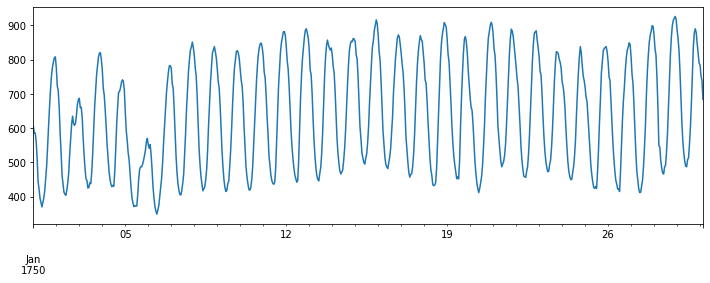

In [17]:
train_series.plot(figsize=(12,4));

Thanks to the slicing mechanism, it is also very easy to zoom on any particular time window within the series. 

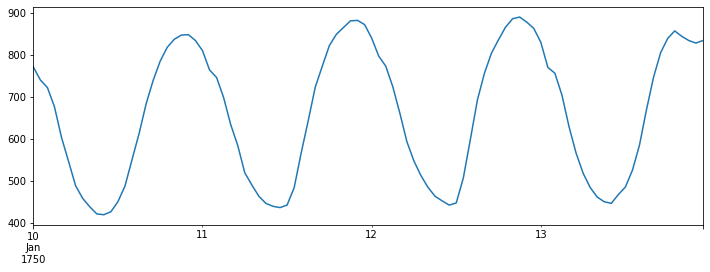

In [18]:
train_series["1750-01-10":"1750-01-13"].plot(figsize=(12,4));

Resampling data by hour (`H`), day (`D`), week (`W`), month (`M`), etc. allows to perform aggregation to different time scales. See below how to plot the aggregated values per day for all days for which we have 24 hourly measurements.

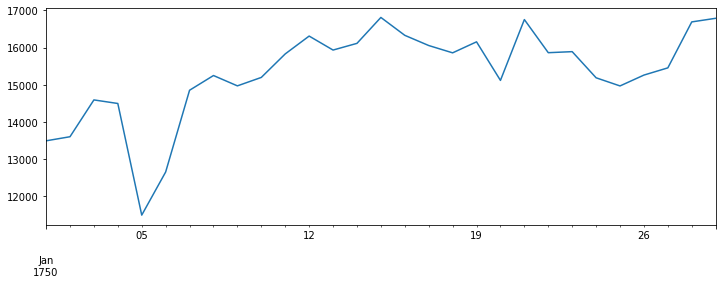

In [19]:
train_series["1750-01-01":"1750-01-29"].resample("D").sum().plot(figsize=(12,4));

<a id='ex'></a>
### <mark>Exercise: Resample and aggregate

- Plot the average value per week.
- Plot the average value per week with weeks starting on Monday. 
    
Hint: Read about [anchoring suffixes](https://pandas.pydata.org/docs/user_guide/timeseries.html#anchored-offsets) and use the corresponding to weekly frequency starting on Monday.

In [20]:
# %load answers/resample1.py


In [21]:
# %load answers/resample2.py


## <a name="3">3. Train and Test Splits in GluonTS Data</a>

(<a href="#0">Go to top</a>)

Datasets pre-loaded in GluonTS already provide a train-test split of the data for the purpose of training and testing forecasting models. 

As mentioned above, the test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.

Let us visualize one of the time series of the M4 hourly dataset and inspect the difference between the train and the test series.

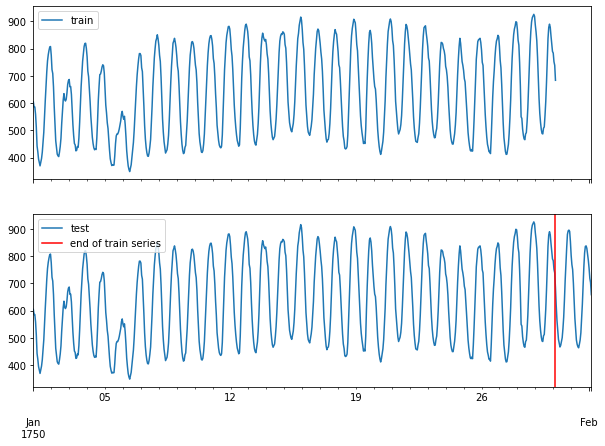

In [22]:
# Get the first time series in the training set
train_entry = next(iter(dataset.train))

# Get the first time series in the test set
test_entry = next(iter(dataset.test))

# Convert the timeseries to pandas series objects to make plotting easier
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].legend(["train"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].legend(["test", "end of train series"], loc="upper left")

plt.show()

In [23]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## **Conclusion**

In this notebook we've shown how to load multivariate time series data using the GluonTS pre-packaged data sets. We have explored how Pandas can seamlessly work with time series data, helping us to visualize and manipulate it. 